In [1]:
!make docker-image > /dev/null 2>&1

In [2]:
!CONTAINER_CMD="bash -lc 'make install-ycsb'" make docker > /dev/null 2>&1

In [3]:
from pathlib import Path
import pexpect
import os
import time

""" Collector class has helper methods to interact with kermit"""
class Collector: 
    def __init__(self, config: Path):
        self.env = os.environ.copy()
        self.env["INTERACTIVE"] = "it"
        self.env["CONTAINER_CMD"] = f"bash -lc 'KERNMLOPS_CONFIG_FILE={config} make collect-data'"
        self.collect_process : pexpect.spawn | None = None

    def start_collection(self, logfile=None):
        self.collect_process = pexpect.spawn("make docker", env=self.env, timeout=None, logfile=logfile)
        self.collect_process.expect_exact(["Started benchmark"])

    def _after_run_generate_file_data() -> dict[str, list[Path]]:
        start_path : Path = Path("./data")
        list_of_collect_id_dirs = start_path.glob("*/*/*")
        latest_collect_id = max(list_of_collect_id_dirs, key=os.path.getctime)
        list_of_files = latest_collect_id.glob("*.*.parquet")
        output = {}
        for f in list_of_files:
            index = str(f).removeprefix(str(f.parent) + "/").split(".")[0]
            if index not in output.keys():
                output[index] = []
            output[index].append(f)
        return output
        
    def wait(self) -> int:
        if self.collect_process is None:
            return
        self.collect_process.expect([pexpect.EOF])
        self.collect_process.wait()
        return Collector._after_run_generate_file_data()
        
    def stop_collection(self):
        if self.collect_process is None:
            return
        self.collect_process.sendline("END")
        return self.wait()

There are two ways to run kermit:
- With the raw config
- With a pre-programmed benchmark config

In [4]:
import subprocess
import sys
collect = Collector("./config/raw_overrides.yaml")
# This creates a raw collector, I suggest looking into this file to learn more

w = open("hello.txt", "bw")
collect.start_collection(logfile=w)
print("Collection has started")
# Start collection

f = open("blah.txt", "w")
bench_test = subprocess.Popen(["cat", "defaults.yaml"], stdout=f)
bench_test.wait()
# Run benchmark application

print("Exit application")
raw_coll_info = collect.stop_collection()
print(raw_coll_info)
# Stop the Collector

Collection has started
Exit application
{'dtlb_misses': [PosixPath('data/curated/faux/0d75071f-7e4f-4aef-b861-3af6cd44d2ac/dtlb_misses.end.parquet')], 'block_io': [PosixPath('data/curated/faux/0d75071f-7e4f-4aef-b861-3af6cd44d2ac/block_io.end.parquet')], 'file_data': [PosixPath('data/curated/faux/0d75071f-7e4f-4aef-b861-3af6cd44d2ac/file_data.end.parquet')], 'system_info': [PosixPath('data/curated/faux/0d75071f-7e4f-4aef-b861-3af6cd44d2ac/system_info.end.parquet')], 'dtlb_walk_duration': [PosixPath('data/curated/faux/0d75071f-7e4f-4aef-b861-3af6cd44d2ac/dtlb_walk_duration.end.parquet')], 'file_opening': [PosixPath('data/curated/faux/0d75071f-7e4f-4aef-b861-3af6cd44d2ac/file_opening.end.parquet')], 'process_metadata': [PosixPath('data/curated/faux/0d75071f-7e4f-4aef-b861-3af6cd44d2ac/process_metadata.end.parquet')], 'tlb_flushes': [PosixPath('data/curated/faux/0d75071f-7e4f-4aef-b861-3af6cd44d2ac/tlb_flushes.end.parquet')], 'itlb_misses': [PosixPath('data/curated/faux/0d75071f-7e4f-4aef

In [5]:
collect = Collector("./config/start_overrides.yaml")
# This is a simple redis benchmark config

w = open("hello.txt", "bw")
collect.start_collection(logfile=w)
# Start collection

start_coll_info = collect.wait()
#Wait for collector to finish

In [6]:
print(raw_coll_info.keys())
print(start_coll_info.keys())

dict_keys(['dtlb_misses', 'block_io', 'file_data', 'system_info', 'dtlb_walk_duration', 'file_opening', 'process_metadata', 'tlb_flushes', 'itlb_misses', 'quanta_runtime', 'memory_usage', 'process_trace', 'quanta_queued_time'])
dict_keys(['dtlb_misses', 'block_io', 'file_data', 'system_info', 'dtlb_walk_duration', 'process_metadata', 'tlb_flushes', 'itlb_misses', 'quanta_runtime', 'memory_usage', 'process_trace', 'quanta_queued_time'])


Now let's try to examine some of the system information from this.
I use polars, you can use whatever you like as far as data frames go, so long as they can read parquet files.

In [7]:
import polars as pl
df = pl.read_parquet(raw_coll_info["file_opening"])
print(df.columns)

['cpu', 'pid', 'tgid', 'ts_uptime_us', 'filename', 'flags', 'mode', 'collection_id']


In [8]:
df

cpu,pid,tgid,ts_uptime_us,filename,flags,mode,collection_id
i64,i64,i64,i64,str,i64,i64,str
1,88001,88001,618524493430,"""""",-1,0,"""0d75071f-7e4f-4aef-b861-3af6cd…"
1,88001,88001,618524493482,"""""",-1,0,"""0d75071f-7e4f-4aef-b861-3af6cd…"
4,82106,82106,618524584501,"""""",-1,0,"""0d75071f-7e4f-4aef-b861-3af6cd…"
4,82106,82106,618524584613,"""""",-1,0,"""0d75071f-7e4f-4aef-b861-3af6cd…"
4,82106,82106,618524785115,"""""",-1,0,"""0d75071f-7e4f-4aef-b861-3af6cd…"
…,…,…,…,…,…,…,…
13,88048,88043,618525032242,"""""",-1,0,"""0d75071f-7e4f-4aef-b861-3af6cd…"
13,88048,88043,618525032286,"""""",-1,0,"""0d75071f-7e4f-4aef-b861-3af6cd…"
13,88048,88043,618525032332,"""""",-1,0,"""0d75071f-7e4f-4aef-b861-3af6cd…"


In [9]:
import pandas as pd

file_opening_df = pd.read_parquet(raw_coll_info["file_opening"])
file_opening_df

,cpu,pid,tgid,ts_uptime_us,filename,flags,mode,collection_id
0,1,88001,88001,618524493430,,-1,0,0d75071f-7e4f-4aef-b861-3af6cd44d2ac
1,1,88001,88001,618524493482,,-1,0,0d75071f-7e4f-4aef-b861-3af6cd44d2ac
2,4,82106,82106,618524584501,,-1,0,0d75071f-7e4f-4aef-b861-3af6cd44d2ac
3,4,82106,82106,618524584613,,-1,0,0d75071f-7e4f-4aef-b861-3af6cd44d2ac
4,4,82106,82106,618524785115,,-1,0,0d75071f-7e4f-4aef-b861-3af6cd44d2ac
...,...,...,...,...,...,...,...,...
1781,13,88048,88043,618525032242,,-1,0,0d75071f-7e4f-4aef-b861-3af6cd44d2ac
1782,13,88048,88043,618525032286,,-1,0,0d75071f-7e4f-4aef-b861-3af6cd44d2ac
1783,13,88048,88043,618525032332,,-1,0,0d75071f-7e4f-4aef-b861-3af6cd44d2ac
1784,13,88048,88043,618525032541,,-1,0,0d75071f-7e4f-4aef-b861-3af6cd44d2ac


In [10]:
file_opening_df["tgid"].value_counts()

tgid
88043    1770
82106       6
88001       4
88075       4
87518       1
84047       1
Name: count, dtype: int64

In [11]:
import pandas as pd

file_data_df = pd.read_parquet(raw_coll_info["file_data"])
file_data_df

,cpu,pid,tgid,ts_uptime_us,file_inode,file_size_bytes,file_name,collection_id
0,0,88045,88043,618510300141,3509210,4096,tmp,0d75071f-7e4f-4aef-b861-3af6cd44d2ac
1,1,88001,88001,618510214576,0,0,gwmv00h3,0d75071f-7e4f-4aef-b861-3af6cd44d2ac
2,1,88001,88001,618510215246,0,0,gwmv00h3,0d75071f-7e4f-4aef-b861-3af6cd44d2ac
3,1,88001,88001,618510215261,3727733,0,gwmv00h3,0d75071f-7e4f-4aef-b861-3af6cd44d2ac
4,1,88001,88001,618510215420,0,0,pyosqsockf2wrffy3,0d75071f-7e4f-4aef-b861-3af6cd44d2ac
...,...,...,...,...,...,...,...,...
7008,14,88043,88043,618510287187,3525621,1259,passwd,0d75071f-7e4f-4aef-b861-3af6cd44d2ac
7009,14,88043,88043,618510298941,3432999,114,UTC,0d75071f-7e4f-4aef-b861-3af6cd44d2ac
7010,15,82068,82060,618513365772,1032229,4096,KernMLOps,0d75071f-7e4f-4aef-b861-3af6cd44d2ac
7011,15,82068,82060,618513689701,1034793,4096,bpf_instrumentation,0d75071f-7e4f-4aef-b861-3af6cd44d2ac


In [12]:
file_data_df["tgid"].value_counts()

tgid
88001    6536
88058     101
88066     101
88059      26
88067      26
88055      25
88064      25
86864      22
88053      16
88043      15
84047      14
88057      13
88065      13
88049      12
88068      12
88060      12
88054      12
88063      12
82060       7
88075       6
1122        4
87427       2
87518       1
Name: count, dtype: int64

In [8]:
import polars as pl
df = pl.read_parquet(raw_coll_info["process_trace"])

def filter_process_trace(process_trace_df: pl.DataFrame) -> pl.DataFrame :
    df = process_trace_df
    # Filter just the processes
    df = df.filter(pl.col("tgid") == pl.col("pid")).drop("collection_id")

    # Find the last name of each process
    start_df = df.sort(pl.col("ts_ns"), descending = True)
    helper_dict = {}
    for row in start_df.iter_rows():
        pid = row[0]
        comm = row[3]
        if pid in helper_dict.keys() or comm == "": 
            continue
        helper_dict[pid] = comm

    # Separate the start and end
    full_df = start_df.with_columns(pl.col("pid").map_elements(lambda x : helper_dict.get(x, ""), return_dtype=str).alias("full_name"))
    full_df = full_df.drop(["tgid", "name"])
    start_df = full_df.filter(pl.col("cap_type") == "start").rename({"ts_ns": "start_ns"}).drop("cap_type")
    end_df = full_df.filter(pl.col("cap_type") == "end").rename({"ts_ns": "end_ns"}).drop(["cap_type", "full_name"])

    # Join them to get the process table
    return start_df.join(end_df, "pid")



In [9]:
filter_process_trace(pl.read_parquet(raw_coll_info["process_trace"]))

pid,start_ns,full_name,end_ns
i64,i64,str,i64
9816,41119260389277,"""cat""",41119264576272


In [10]:
filter_process_trace(pl.read_parquet(start_coll_info["process_trace"]))

pid,start_ns,full_name,end_ns
i64,i64,str,i64
10420,41189883589876,"""redis-cli""",41189888050918
10392,41189229794961,"""java""",41189655846571
10332,41179631454230,"""mvn""",41179631690202
10331,41179630563942,"""mvn""",41179630823428
10330,41179630109026,"""mvn""",41179630335085
…,…,…,…
10073,41144573068618,"""pwd""",41144575554154
10072,41144455618938,"""python""",41179522528315
10071,41144443215233,"""redis-cli""",41144446548452


In [11]:
import polars as pl

def filter_process_trace(process_trace_df: pl.DataFrame) -> pl.DataFrame :
    df = process_trace_df
    # Filter just the processes
    df = df.filter(pl.col("tgid") == pl.col("pid")).drop("collection_id")

    # Find the last name of each process
    start_df = df.sort(pl.col("ts_ns"), descending = True)
    helper_dict = {}
    for row in start_df.iter_rows():
        pid = row[0]
        comm = row[3]
        if pid in helper_dict.keys() or comm == "": 
            continue
        helper_dict[pid] = comm

    # Separate the start and end
    full_df = start_df.with_columns(pl.col("pid").map_elements(lambda x : helper_dict.get(x, ""), return_dtype=str).alias("full_name"))
    full_df = full_df.drop(["tgid", "name"])
    start_df = full_df.filter(pl.col("cap_type") == "start").rename({"ts_ns": "start_ns"}).drop("cap_type")
    end_df = full_df.filter(pl.col("cap_type") == "end").rename({"ts_ns": "end_ns"}).drop(["cap_type", "full_name"])

    # Join them to get the process table
    combined_df = start_df.join(end_df, "pid")
    return combined_df.with_columns((pl.col("end_ns") - pl.col("start_ns")).alias("duration"))

def process_trace_start_end_ts(process_trace_df: pl.DataFrame, proc_name: str, index: int) ->(int, int, int):
    trace_df = filter_process_trace(process_trace_df).sort(pl.col("start_ns"))
    df = trace_df.filter(pl.col("full_name") == proc_name)
    print(df)
    df = df[index]
    pid = df["pid"][0]
    start_ns = df["start_ns"][0]
    end_ns = df["end_ns"][0]
    return pid, start_ns, end_ns

def clean_rss_pid(rss_df: pl.DataFrame, pid: int) -> pl.DataFrame:
    df = rss_df.drop(["pid", "collection_id"]).sort(pl.col("ts_ns"))
    df = df.filter(pl.col("tgid") == pid)
    df = df.with_columns(pl.when(pl.col("member") == "MM_FILEPAGES")
                     .then(pl.col("count"))
                     .otherwise(None)
                     .fill_null(strategy="forward")
                     .fill_null(strategy="backward")
                     .alias("file"))
    df = df.with_columns(pl.when(pl.col("member") == "MM_ANONPAGES")
                     .then(pl.col("count"))
                     .otherwise(None)
                     .fill_null(strategy="forward")
                     .fill_null(strategy="backward")
                     .alias("anon"))
    df = df.with_columns(pl.when(pl.col("member") == "MM_SWAPENTS")
                     .then(pl.col("count"))
                     .otherwise(None)
                     .fill_null(strategy="forward")
                     .fill_null(strategy="backward")
                     .alias("swap"))
    df = df.drop(["member", "count"])
    zero_df = pl.DataFrame({"tgid": pid, "ts_ns" : -1, "file" : 0, "anon": 0, "swap": 0})
    df = pl.concat([df, zero_df]).sort("ts_ns")
    df = df.fill_null(strategy="forward")
    df = df.filter(pl.col("ts_ns") >= 0)
    df = df.with_columns((pl.col("file") + pl.col("anon") + pl.col("swap")).alias("count"))
    df = df.drop(["file", "anon", "swap"])
    return df

def filter_rss_with_ts(rss_trace_df: pl.DataFrame, start: int, end: int):
    print(start, end)
    new_frame_dict = {}
    for column_name in rss_trace_df.columns:
        new_frame_dict[column_name] = [None, None]
    new_frame_dict["ts_ns"] = [start, end]
    df = rss_trace_df.vstack(pl.DataFrame(new_frame_dict))
    df = df.sort(pl.col("ts_ns")).fill_null(strategy="forward").fill_null(strategy="backward")
    return df.filter(pl.col("ts_ns").is_between(start, end, closed='both'))

def get_proper_rss(proc_path: Path, rss_path: Path, rss_name: str, rss_ind: int, runner_name: str, runner_ind: int, tag:str):
    proc_trace_df = pl.read_parquet(proc_path)
    rss_df = pl.read_parquet(rss_path)

    _, start, end = process_trace_start_end_ts(proc_trace_df, runner_name, runner_ind)
    pid, _, _ = process_trace_start_end_ts(proc_trace_df, rss_name, rss_ind)
    clean_rss_df = filter_rss_with_ts(clean_rss_pid(rss_df, pid), start, end)
    return clean_rss_df.with_columns((pl.col("ts_ns") - pl.min("ts_ns")).alias("norm_ts_ns")).with_columns(pl.lit(tag).alias('policy'))

from pathlib import Path
from plotnine import ggplot, aes, geom_line, geom_point, labs

def create_graph(inputs: [(str, dict[str, Path])], proc_tag: str, proc_ind: int, time_proc_tag: str, time_proc_index: int, title: str) -> None:
    df = pl.DataFrame()
    for (tag, filedict) in inputs:
        append_df = get_proper_rss(filedict["process_trace"],
                                   filedict["mm_rss_stat"],
                                   proc_tag, proc_ind,
                                   time_proc_tag,
                                   time_proc_index,
                                   tag).drop(["tgid", "ts_ns"])
        df = pl.concat([df, append_df])
    df = df.with_columns((pl.col("norm_ts_ns") / (10**9)/ 60).alias("norm_ts_mins"))
    plt0 = (ggplot(df)
            + aes("norm_ts_mins", y="count", colour="policy")
            + geom_point()
            + geom_line()
            + labs(x="Time (mins)",
                   y="4kB Pages",
                   title=title)
           )
    return plt0

In [12]:
collect = Collector("./config/redis_never.yaml")
collect.start_collection(None)
redis_never_info = collect.wait()
collect = Collector("./config/redis_madvise.yaml")
collect.start_collection(None)
redis_madvise_info = collect.wait()
collect = Collector("./config/redis_always.yaml")
collect.start_collection(None)
redis_always_info = collect.wait()

In [13]:
from IPython.display import Image, display
plt = create_graph([("4k", redis_never_info),
                    ("madvise", redis_madvise_info),
                    ("thp", redis_always_info)],
                   "redis-server", 0, 
                   "redis-server", 0,
                   "Redis driven by YCSB with Insertions and Deletes using Jemalloc")
plt.save("deletes-redis.png")

shape: (1, 5)
┌───────┬────────────────┬──────────────┬────────────────┬─────────────┐
│ pid   ┆ start_ns       ┆ full_name    ┆ end_ns         ┆ duration    │
│ ---   ┆ ---            ┆ ---          ┆ ---            ┆ ---         │
│ i64   ┆ i64            ┆ str          ┆ i64            ┆ i64         │
╞═══════╪════════════════╪══════════════╪════════════════╪═════════════╡
│ 10730 ┆ 41219733247167 ┆ redis-server ┆ 41290590188015 ┆ 70856940848 │
└───────┴────────────────┴──────────────┴────────────────┴─────────────┘
shape: (1, 5)
┌───────┬────────────────┬──────────────┬────────────────┬─────────────┐
│ pid   ┆ start_ns       ┆ full_name    ┆ end_ns         ┆ duration    │
│ ---   ┆ ---            ┆ ---          ┆ ---            ┆ ---         │
│ i64   ┆ i64            ┆ str          ┆ i64            ┆ i64         │
╞═══════╪════════════════╪══════════════╪════════════════╪═════════════╡
│ 10730 ┆ 41219733247167 ┆ redis-server ┆ 41290590188015 ┆ 70856940848 │
└───────┴──────────────

/users/phillipd/KernMLOps/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/users/phillipd/KernMLOps/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: deletes-redis.png


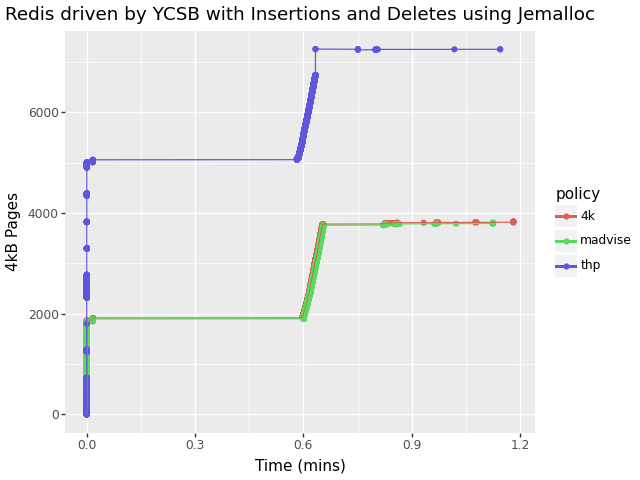

In [14]:
Image(filename="./deletes-redis.png")